In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
data_dir = "/kaggle/input/parkinsons-drawings/spiral"

train_dataset = datasets.ImageFolder(root=f"{data_dir}/training", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/testing", transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

In [ ]:
weights = torchvision.models.VGG19_Weights.IMAGENET1K_V1
model = torchvision.models.vgg19(weights=weights).to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = 2
model.classifier  = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=25088,
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
    model.to(device)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
model = model
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 30
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_loader,
               model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device,
               train_losses=train_losses,
               train_accuracy=train_accuracy
    )
    test(data_loader=test_loader,
              model=model,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device,
              test_losses=test_losses,
              test_accuracy=test_accuracy
    )

In [ ]:
torch.save(model.state_dict(), "vgg_healthy_parkinsons.pth")
print("Model saved.")

In [ ]:
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(train_accuracy)
plt.title('train_accuracy')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('step')
plt.ylabel('percent')

## Implementation of **Approximate Linear Weights** introduced in the paper

**Approximate Linear Weights (ALW)** aims to approximate the complex structure of the Deep Neural Network into a linear model that achieves similar accuracies as the Neural Network.

ALW is computed using the **Layerwise Relevancy Propagation (LRP)** values extracted at the input layer of the neural network for each input and class and produces a weight matrix for every class.

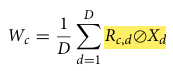

In [ ]:
def relevance_filter(r: torch.tensor, top_k_percent: float = 1.0) -> torch.tensor:
    assert 0.0 < top_k_percent <= 1.0

    if top_k_percent < 1.0:
        size = r.size()
        r = r.flatten(start_dim=1)
        num_elements = r.size(-1)
        k = max(1, int(top_k_percent * num_elements))
        top_k = torch.topk(input=r, k=k, dim=-1)
        r = torch.zeros_like(r)
        r.scatter_(dim=1, index=top_k.indices, src=top_k.values)
        return r.view(size)
    else:
        return r

In [ ]:
class RelevancePropagationAdaptiveAvgPool2d(nn.Module):

    def __init__(
        self,
        layer: torch.nn.AdaptiveAvgPool2d,
        eps: float = 1.0e-05,
        top_k: float = 0.0,
    ) -> None:
        super().__init__()
        self.layer = layer
        self.eps = eps
        self.top_k = top_k

    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        if self.top_k:
            r = relevance_filter(r, top_k_percent=self.top_k)
        z = self.layer.forward(a) + self.eps
        s = (r / z).data
        (z * s).sum().backward()
        c = a.grad
        r = (a * c).data
        return r


class RelevancePropagationAvgPool2d(nn.Module):

    def __init__(
        self, layer: torch.nn.AvgPool2d, eps: float = 1.0e-05, top_k: float = 0.0
    ) -> None:
        super().__init__()
        self.layer = layer
        self.eps = eps
        self.top_k = top_k

    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        if self.top_k:
            r = relevance_filter(r, top_k_percent=self.top_k)
        z = self.layer.forward(a) + self.eps
        s = (r / z).data
        (z * s).sum().backward()
        c = a.grad
        r = (a * c).data
        return r


class RelevancePropagationMaxPool2d(nn.Module):

    def __init__(
        self,
        layer: torch.nn.MaxPool2d,
        mode: str = "avg",
        eps: float = 1.0e-05,
        top_k: float = 0.0,
    ) -> None:
        super().__init__()

        if mode == "avg":
            self.layer = torch.nn.AvgPool2d(kernel_size=(2, 2))
        elif mode == "max":
            self.layer = layer

        self.eps = eps
        self.top_k = top_k

    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        if self.top_k:
            r = relevance_filter(r, top_k_percent=self.top_k)
        z = self.layer.forward(a) + self.eps
        s = (r / z).data
        (z * s).sum().backward()
        c = a.grad
        r = (a * c).data
        return r


class RelevancePropagationConv2d(nn.Module):

    def __init__(
        self,
        layer: torch.nn.Conv2d,
        mode: str = "z_plus",
        eps: float = 1.0e-05,
        top_k: float = 0.0,
    ) -> None:
        super().__init__()

        self.layer = layer

        if mode == "z_plus":
            self.layer.weight = torch.nn.Parameter(self.layer.weight.clamp(min=0.0))
            self.layer.bias = torch.nn.Parameter(torch.zeros_like(self.layer.bias))

        self.eps = eps
        self.top_k = top_k

    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        if self.top_k:
            r = relevance_filter(r, top_k_percent=self.top_k)
        z = self.layer.forward(a) + self.eps
        s = (r / z).data
        (z * s).sum().backward()
        c = a.grad
        r = (a * c).data
        return r


class RelevancePropagationLinear(nn.Module):

    def __init__(
        self,
        layer: torch.nn.Linear,
        mode: str = "z_plus",
        eps: float = 1.0e-05,
        top_k: float = 0.0,
    ) -> None:
        super().__init__()

        self.layer = layer

        if mode == "z_plus":
            self.layer.weight = torch.nn.Parameter(self.layer.weight.clamp(min=0.0))
            self.layer.bias = torch.nn.Parameter(torch.zeros_like(self.layer.bias))

        self.eps = eps
        self.top_k = top_k

    @torch.no_grad()
    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        if self.top_k:
            r = relevance_filter(r, top_k_percent=self.top_k)
        z = self.layer.forward(a) + self.eps
        s = r / z
        c = torch.mm(s, self.layer.weight)
        r = (a * c).data
        return r


class RelevancePropagationFlatten(nn.Module):

    def __init__(self, layer: torch.nn.Flatten, top_k: float = 0.0) -> None:
        super().__init__()
        self.layer = layer

    @torch.no_grad()
    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        r = r.view(size=a.shape)
        return r


class RelevancePropagationReLU(nn.Module):

    def __init__(self, layer: torch.nn.ReLU, top_k: float = 0.0) -> None:
        super().__init__()

    @torch.no_grad()
    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        return r


class RelevancePropagationDropout(nn.Module):
    def __init__(self, layer: torch.nn.Dropout, top_k: float = 0.0) -> None:
        super().__init__()

    @torch.no_grad()
    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        return r


class RelevancePropagationIdentity(nn.Module):
    def __init__(self, layer: nn.Module, top_k: float = 0.0) -> None:
        super().__init__()

    @torch.no_grad()
    def forward(self, a: torch.tensor, r: torch.tensor) -> torch.tensor:
        return r

In [ ]:
def layers_lookup() -> dict:
    lookup_table = {
        torch.nn.modules.linear.Linear: RelevancePropagationLinear,
        torch.nn.modules.conv.Conv2d: RelevancePropagationConv2d,
        torch.nn.modules.activation.ReLU: RelevancePropagationReLU,
        torch.nn.modules.dropout.Dropout: RelevancePropagationDropout,
        torch.nn.modules.flatten.Flatten: RelevancePropagationFlatten,
        torch.nn.modules.pooling.AvgPool2d: RelevancePropagationAvgPool2d,
        torch.nn.modules.pooling.MaxPool2d: RelevancePropagationMaxPool2d,
        torch.nn.modules.pooling.AdaptiveAvgPool2d: RelevancePropagationAdaptiveAvgPool2d,
    }
    return lookup_table

## The Layerwise Relevancy Propagation Model

In [ ]:
class LRPModel(nn.Module):

    def __init__(self, model: torch.nn.Module, top_k: float = 0.0) -> None:
        super().__init__()
        self.model = model
        self.top_k = top_k

        self.model.eval()
        self.layers = self._get_layer_operations()
        self.lrp_layers = self._create_lrp_model()

    def _create_lrp_model(self) -> torch.nn.ModuleList:
        layers = deepcopy(self.layers)
        lookup_table = layers_lookup()
        for i, layer in enumerate(layers[::-1]):
            try:
                layers[i] = lookup_table[layer.__class__](layer=layer, top_k=self.top_k)
            except KeyError:
                message = (
                    f"Layer-wise relevance propagation not implemented for "
                    f"{layer.__class__.__name__} layer."
                )
                raise NotImplementedError(message)

        return layers

    def _get_layer_operations(self) -> torch.nn.ModuleList:
        layers = torch.nn.ModuleList()
        for layer in self.model.features:
            layers.append(layer)

        layers.append(self.model.avgpool)
        layers.append(torch.nn.Flatten(start_dim=1))

        for layer in self.model.classifier:
            layers.append(layer)

        return layers

    def forward(self, x: torch.tensor, class_idx: int = None) -> torch.tensor:
        activations = list()
        with torch.no_grad():
            activations.append(torch.ones_like(x))
            for layer in self.layers:
                x = layer.forward(x)
                activations.append(x)

        activations = activations[::-1]
        activations = [a.data.requires_grad_(True) for a in activations]
        logits = activations.pop(0)
        if class_idx is not None:
            relevance = torch.zeros_like(logits)
            x = torch.softmax(logits, dim=-1)
            relevance[:, class_idx] = x[0][class_idx]
            # print(relevance)
        else:
            relevance = torch.softmax(logits, dim=-1)
            print(relevance)
        for i, layer in enumerate(self.lrp_layers):
            relevance = layer.forward(activations.pop(0), relevance)

        return relevance.permute(0, 2, 3, 1).sum(dim=-1).squeeze().detach().cpu()

    def inference(self, x: torch.tensor) -> torch.tensor:
        self.model.eval()
        return self.model(x)


tensor([[0.6776, 0.3224]], grad_fn=<SoftmaxBackward0>)


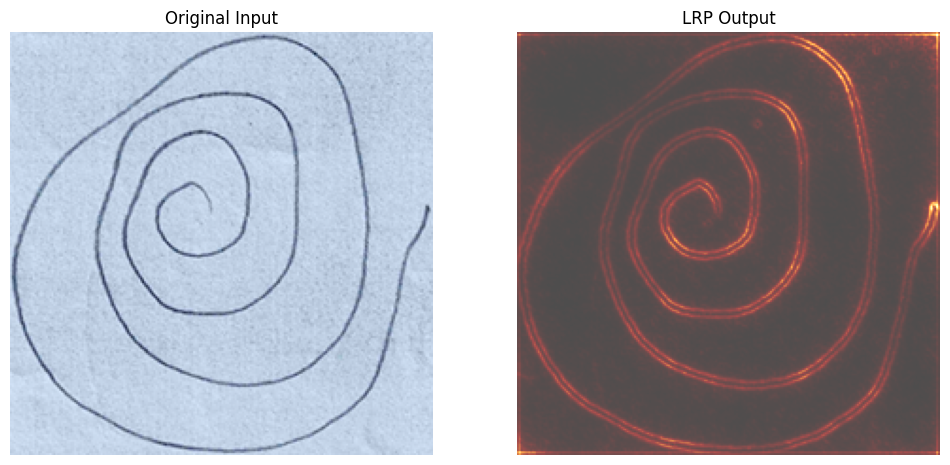

In [ ]:
image_path = r'C:\Users\alanj\XAI\content\park.png'
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
x = transform(image).unsqueeze(0)
model = torchvision.models.vgg19().to(device)
for param in model.parameters():
    param.requires_grad = False
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = 2
model.classifier  = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=25088,
                    out_features=output_shape,
                    bias=True)).to(device)
model.load_state_dict(torch.load(r"C:/Users/alanj/XAI/content/vgg_healthy_parkinsons.pth", weights_only=True))
lrp_model = LRPModel(model)
r = lrp_model.forward(x,class_idx=0)
x_image = x.squeeze().permute(1, 2, 0).cpu().numpy()
x_image = (x_image - x_image.min()) / (x_image.max() - x_image.min())
r_image = r.squeeze().cpu().numpy()
r_image = (r_image - r_image.min()) / (r_image.max() - r_image.min())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(x_image)
axes[0].set_title("Original Input")
axes[0].axis('off')

# Plot LRP output as a heatmap
axes[1].imshow(r_image, cmap='afmhot', alpha=0.7)
axes[1].set_title("LRP Output")
axes[1].axis('off')
plt.show()

## ALW - Approximate Linear Weights (ALW) on images

In [ ]:
def conv2d(m1,m2):
    # print(np.multiply(m1,m2).shape)
    return np.multiply(m1,m2).sum()

In [ ]:
def ALW_inside_operation(R_c_d, X):
    X_eps = X + 0.001 #avoiding 0 divide error
    return R_c_d/X_eps

In [ ]:
# X.shape

In [ ]:
def ALW_class_wise(X,cls):
    l_X = len(X)
    alw = np.zeros_like(X[0])
    for d in range(l_X):
        # ip = cv2.CvtColor(X[d][0], cv2.COLOR_RGB2GRAY)
        ip = np.expand_dims(X[d],axis=0)
        ip = torch.tensor(ip)
        R_c_d = lrp_model.forward(ip,class_idx=cls)
        # print(R_c_d.shape)
        s2 = ALW_inside_operation(R_c_d, X[d])
        alw = np.add(alw, s2)
    # print(alw.shape)
    return alw/l_X

In [ ]:
def ALW(X,classes):
    alw_weights = []
    l_cls = len(classes)
    for cls in range(l_cls):
        alw_weights.append(ALW_class_wise(X,cls))
    return alw_weights

In [ ]:
def convRGB2GRAY(X):
    r, g, b = X[0,:,:], X[1,:,:], X[2,:,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [ ]:
#test
X = x.detach().clone().numpy()
# X = cv2.CvtColor(X, cv2.COLOR_RGB2GRAY)
classes = [0,1]
alw_weights = ALW(X,classes)
# print(alw_weights[0].shape)

computeClassScores(X[0].astype(np.float32), alw_weights)

tensor([[0.6776, 0.3224]], grad_fn=<SoftmaxBackward0>)
tensor([[0.6776, 0.3224]], grad_fn=<SoftmaxBackward0>)


array([0.743651  , 0.25634903], dtype=float32)

## Testing the Linear approximation of the fine-tuned VGG-19 Neural Network

In [ ]:
def computeClassScores(X, alw_weights):
    # X_gray = convRGB2GRAY(X)
    x = [conv2d(X, W_c) for W_c in alw_weights]
    return np.exp(x)/sum(np.exp(x))

In [ ]:
#testing the linear model
def testLinearModel(X_test, alw_weights):
    original_model_ops = []
    approx_model_ops = []
    for i in X_test:
        ip = np.expand_dims(i,axis=0)
        ip = torch.tensor(ip)
        original_model_ops += torch.softmax(model(ip),dim=-1).tolist()
        approx_model_ops.append(computeClassScores(i.astype(np.float32), alw_weights).tolist())
    return original_model_ops, approx_model_ops


## Class 0 is Healthy class, Class 1 is Parkinsons

In [ ]:
testLinearModel(X,alw_weights)

([[0.6776184439659119, 0.32238152623176575]],
 [[0.7436509728431702, 0.25634902715682983]])

In [ ]:
X[0].shape

(3, 224, 224)

In [ ]:
#Testing on Healthy class of data
healthy_test_list = os.listdir(r'content\spiral\testing\healthy')
healthy_test_data = [transform(Image.open(r'content/spiral/testing/healthy/'+i).convert("RGB")).numpy() for i in healthy_test_list]
len(healthy_test_data)

15

In [ ]:
testLinearModel(healthy_test_data, alw_weights)

([[0.7560583353042603, 0.24394161999225616],
  [0.09806126356124878, 0.9019386768341064],
  [0.7056810855865479, 0.29431894421577454],
  [0.9045181274414062, 0.09548190981149673],
  [0.6373344659805298, 0.36266547441482544],
  [0.9436392188072205, 0.05636078864336014],
  [0.945772111415863, 0.05422789976000786],
  [0.9528448581695557, 0.04715516045689583],
  [0.9956455826759338, 0.004354438278824091],
  [0.9463440775871277, 0.05365585535764694],
  [0.3949504792690277, 0.6050495505332947],
  [0.9948293566703796, 0.0051706344820559025],
  [0.999251663684845, 0.0007482981309294701],
  [0.9966874718666077, 0.003312488552182913],
  [0.9908187985420227, 0.009181219153106213]],
 [[0.7517179250717163, 0.2482820600271225],
  [0.7689628005027771, 0.2310372292995453],
  [0.7587525844573975, 0.24124741554260254],
  [0.753329873085022, 0.24667014181613922],
  [0.7532196044921875, 0.24678035080432892],
  [0.7582096457481384, 0.24179033935070038],
  [0.7611376047134399, 0.23886241018772125],
  [0.762

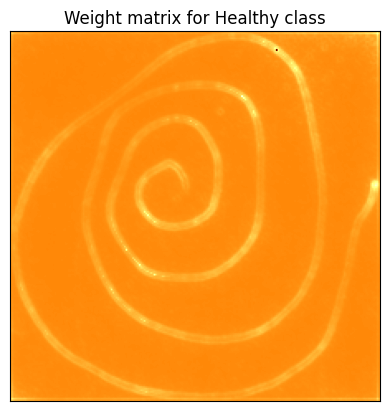

In [ ]:
#plotting the weight matrix
plt.imshow(alw_weights[0][0],cmap='afmhot')
plt.title("Weight matrix for Healthy class")
plt.xticks([])
plt.yticks([])
plt.show()